In [24]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.distributions import MultivariateNormal
import numpy as np

%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import json
from typing import Tuple, Optional, Dict
import torch
import gymnasium as gym

from env import MazeEnv

from simulate import simulation_config , train, evaluate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# affichage des temps des différents fonctins pour optimisartion


# import cProfile
# import pstats
# from io import StringIO

# def profile_code():
#     agent = train()
#     pass


# pr = cProfile.Profile()
# pr.enable()
# profile_code()
# pr.disable()
# s = StringIO()
# sortby = 'cumulative'  # Vous pouvez aussi essayer 'tottime' pour le temps total
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)

# # Limiter le nombre de fonctions affichées
# ps.print_stats(10)  # Affiche les 10 fonctions les plus consommatrices de temps

# print(s.getvalue())



Simulation interrupted by the user
Interval is larger than the number of episodes. Skipping moving average.


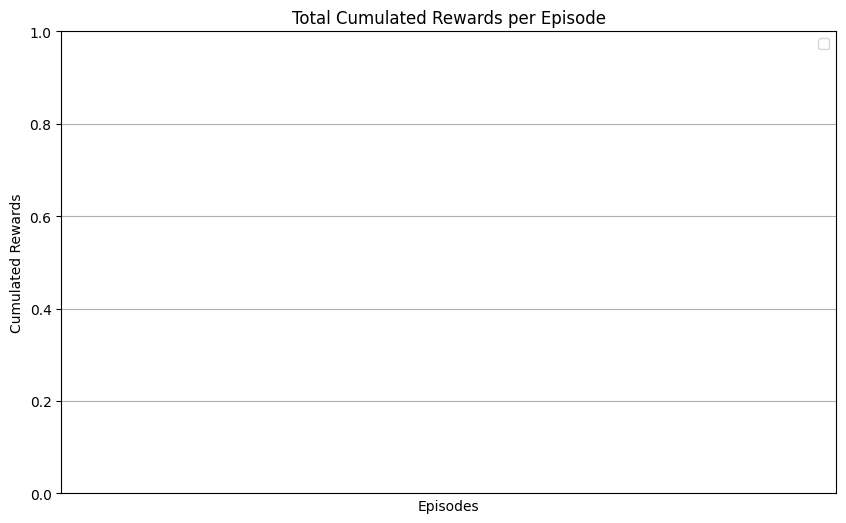

Interval is larger than the number of episodes. Skipping moving average.


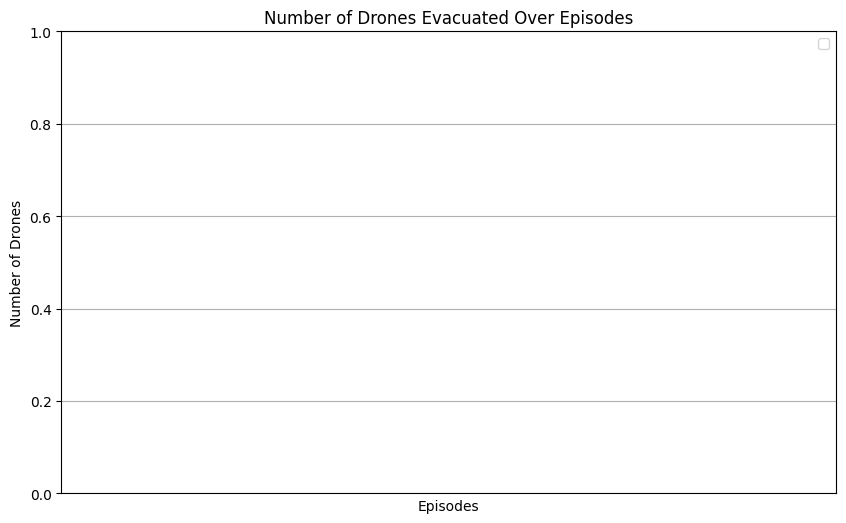

Interval is larger than the number of episodes. Skipping moving average.


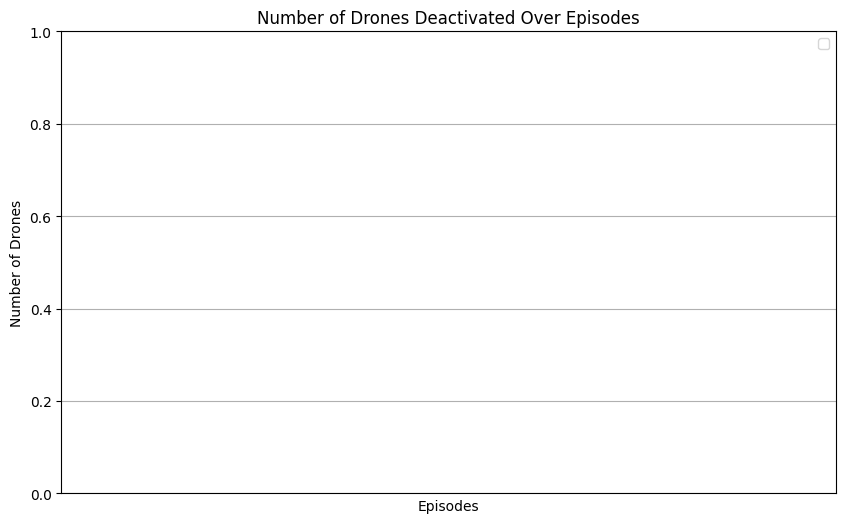

In [25]:
agent = train()

In [14]:
# Load the trained agent
all_results = evaluate(configs_paths=['config.json'], trained_agent=agent)


--- Evaluating Configuration: config.json ---
Episode 1/10, Step 113, Reward: -200.11, Evacuated: 0, Deactivated: 0
Pygame window closed

Simulation interrupted by the user


In [58]:
# pilote agent :

import  time


config_path="config.json"
env, agent, config = simulation_config(config_path,new_agent=True)
n_agents = env.num_agents

next_states, info = env.reset()  # (n_agents, obs_dim)

while True : 
    time.sleep(1)
    print(get_possible_actions(next_states[0]))
    time.sleep(1)
    actions = [int(input())]

    next_states, rewards, dones, _ ,info= env.step(actions)  
    print(next_states)
    if dones:
        next_states, info = env.reset()



down :  (np.float32(5.0), np.float32(0.0))
left : (np.float32(1.0), np.float32(1.0))
right :  (np.float32(1.0), np.float32(1.0))
[0, 2, 5, 6]
[[ 1. 14.  2.  0. 14.  0.  5.  0.  3.  0.  1.  1.]]
down :  (np.float32(5.0), np.float32(0.0))
left : (np.float32(3.0), np.float32(0.0))
right :  (np.float32(1.0), np.float32(1.0))
[0, 2, 3, 5, 6]
[[ 1. 13.  2.  0. 14.  0.  5.  0.  3.  0.  2.  1.]]
down :  (np.float32(5.0), np.float32(0.0))
left : (np.float32(3.0), np.float32(0.0))
right :  (np.float32(2.0), np.float32(1.0))
[0, 2, 3, 4, 5, 6]
[[ 1. 12.  2.  0. 14.  0.  3.  1.  3.  0.  3.  1.]]
down :  (np.float32(3.0), np.float32(1.0))
left : (np.float32(3.0), np.float32(0.0))
right :  (np.float32(3.0), np.float32(1.0))
[0, 2, 3, 4, 5, 6]
[[ 1. 11.  2.  0. 14.  0.  5.  0.  3.  1.  3.  0.]]
down :  (np.float32(5.0), np.float32(0.0))
left : (np.float32(3.0), np.float32(1.0))
right :  (np.float32(3.0), np.float32(0.0))
[0, 2, 3, 4, 5, 6]
[[ 1. 10.  2.  0. 14.  0.  5.  0.  2.  1.  3.  0.]]
down :  (

KeyboardInterrupt: Interrupted by user

In [57]:
def get_possible_actions(state):
    x, y, orientation = state[0], state[1], int(state[2])
    lidar_main_dist, lidar_main_type = state[6], state[7]
    lidar_right_dist, lidar_right_type = state[8], state[9]
    lidar_left_dist, lidar_left_type = state[10], state[11]
    
    possible_actions = {0, 5, 6}  # steady et rotations toujours possibles
    
    # Déterminer quel lidar correspond à quelle direction dans la grille
    if orientation == 0:  # Agent orienté vers le haut
        up,  left, right = (lidar_main_dist, lidar_main_type), (lidar_left_dist, lidar_left_type), (lidar_right_dist, lidar_right_type)
    elif orientation == 1:  # Agent orienté vers la droite
        up, down, right = (lidar_left_dist, lidar_left_type), (lidar_right_dist, lidar_right_type), (lidar_main_dist, lidar_main_type)
    elif orientation == 2:  # Agent orienté vers le bas
       down, left, right =  (lidar_main_dist, lidar_main_type), (lidar_right_dist, lidar_right_type), (lidar_left_dist, lidar_left_type)
    else:  # Agent orienté vers la gauche
        up, down, left  =  (lidar_right_dist, lidar_right_type), (lidar_left_dist, lidar_left_type), (lidar_main_dist, lidar_main_type)


    # Vérifier les déplacements en fonction des obstacles détectés
    try : 
        print("UP ", up)
        if up[1] == 2 or up[0] > 2:
            possible_actions.add(1)
        if up[1] == 0  or up[0] > 1:
            possible_actions.add(1)  # up (vers le haut de la grille)
    except :
        pass
    try : 
        print("down : ", down)
        if down[1] == 2 or down[0] > 2:
            possible_actions.add(2)
        if down[1] == 0  or down[0] > 1:
            possible_actions.add(2)  # down (vers le bas de la grille)
    except : pass
    try :
        print("left :", left)
        if left[1] == 2 or left[0] > 2:
            possible_actions.add(3)
        if left[1] == 0  or left[0] > 1:
            possible_actions.add(3) # left (vers la gauche de la grille)
    except: pass
    try : 
        print("right : ", right)
        if right[1] == 2 or right[0] > 2:
            possible_actions.add(4)
        if right[1] == 0  or right[0] > 1:
            possible_actions.add(4) # right (vers la droite de la grille)
    except : pass
    return list(possible_actions)
